In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision import transforms as T
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import InterpolationMode as Inter
import json
import collections
from sklearn.cluster import KMeans
import os
import torch

/Users/feiwu/opt/anaconda3/envs/torch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dataset import DataHandler
from routes import CLASS_ID_TYPE, FRAME_KEYWORD, FILE_TYPE
from utils import set_random
from main import config

In [4]:
DATAPATH = "../../datasets/youtube_VOS/skateboard/"
IMG_PATH = DATAPATH + 'images/'
LAB_PATH = DATAPATH + 'labels/'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# functions

In [5]:
from dataset import chose_labeled, divide_data_split


def set_exp_variable():
    SEED = 1
    set_random(SEED)
    train_data, val_data, test_data = divide_data_split(IMG_PATH, LAB_PATH, SEED=SEED, data_path=DATAPATH)
    test_imgTrans = T.Compose([
        T.Resize((config['IMG_SIZE'], config['IMG_SIZE2']),
                    interpolation=Inter.BILINEAR),
    ])
    test_labelTrans = T.Compose([
        T.Resize((config['IMG_SIZE'], config['IMG_SIZE2']),
                    interpolation=Inter.NEAREST)
    ])
    
    curr_labeled = collections.defaultdict(list)
    ind_keyword = len(LAB_PATH + CLASS_ID_TYPE)
    for class_ID, data_paths in train_data.items():
        inds = [int(0.5 * len(data_paths))]
        # inds = np.arange(len(data_paths))
        L = []
        for ind in inds:
            mask_path = data_paths[ind][1]
            number = mask_path[ind_keyword +
                                len(FRAME_KEYWORD):-len(FILE_TYPE)]
            L.append(number)
        curr_labeled[class_ID] = L

    # with open(EXP_FOLDER + f'curr_labeled_SEED={SEED}_round={8}.json', 'r') as f:
    #     curr_labeled = json.load(f)
    # with open(EXP_FOLDER + f'new_labeled_SEED={SEED}_round={8}.json', 'r') as f:
    #     new_labeled = json.load(f)
    # for k, v in new_labeled.items():
    #     curr_labeled[k] = curr_labeled[k] + v
    ### SET UP TRAIN DATASET ###
    set_random(SEED)  # to have the same model parameters

    ### SET UP TRAIN DATASET ###
    labeled_train, unlabeled_train, all_train = chose_labeled(
            train_data, labeled=curr_labeled, lab_path=LAB_PATH)

    train_dataset = DataHandler(data_path=labeled_train,
                                img_trans=test_imgTrans,
                                label_trans=test_labelTrans, 
                                lab_path=LAB_PATH,
                                path=DATAPATH)

    all_train_dataset = DataHandler(data_path=all_train,
                                    img_trans=test_imgTrans,
                                    label_trans=test_labelTrans,
                                    lab_path=LAB_PATH,
                                    path=DATAPATH)

    val_dataset = DataHandler(data_path=val_data,
                                img_trans=test_imgTrans,
                                label_trans=test_labelTrans,
                                lab_path=LAB_PATH,
                                path=DATAPATH)

    test_dataset = DataHandler(data_path=test_data,
                                img_trans=test_imgTrans,
                                label_trans=test_labelTrans,
                                lab_path=LAB_PATH,
                                path=DATAPATH)
                                
    unlabeled_dataset = DataHandler(data_path=unlabeled_train,
                                    img_trans=test_imgTrans,
                                    label_trans=test_labelTrans,
                                    lab_path=LAB_PATH,
                                    path=DATAPATH)

    print(
        f"sampling is: {config['SAMPLING']}\n" + \
        f"metric is: {config['METRIC']}\n" + \
        f"number of labeled train frames: {len(train_dataset.data_pool)}\n" + \
        f"number of train frames: {len(all_train_dataset.data_pool)}\n" + \
        f"number of val frames: {len(val_dataset.data_pool)}\n" + \
        f"number of test frames: {len(test_dataset.data_pool)}\n" + \
        f"first dataset sample: {train_dataset.data_pool[0][0]}\n")

    return train_dataset, all_train_dataset

# Compute Embeddings

In [6]:
train_dataset, all_train_dataset = set_exp_variable()

sampling is: k_means_fulldataset_center
metric is: AUROC
number of labeled train frames: 14
number of train frames: 396
number of val frames: 305
number of test frames: 270
first dataset sample: ../../datasets/youtube_VOS/skateboard/images/984f0f1c36/00090.jpg



## resnet embedding

In [12]:
from utils import resnet_embedding

In [13]:
all_train_dataloader = DataLoader(all_train_dataset,
                                    batch_size=128,
                                    shuffle=False)

In [14]:
embedding_name = 'embeddings_resnet_layer2-3_SEED=0.pth'
if os.path.isfile(f'embeddings/{embedding_name}'):
    embeddings = torch.load(f'embeddings/{embedding_name}')
else:
    embeddings = resnet_embedding(all_train_dataloader)
    torch.save(embeddings, f'embeddings/{embedding_name}')
embeddings = np.stack(list(embeddings.values()))

## simCLR embedding

In [7]:
from utils import simCLR_embedding

In [8]:
embedding_name = 'embeddings_simCLR.pth'
weight_path = '../../experiments/simCLR/allVideos_skateboard/v1/0/checkpoints/pretrained_epoch=408.pth.tar'
if os.path.isfile(f'embeddings/{embedding_name}'):
    embeddings = torch.load(f'embeddings/{embedding_name}')
else:
    embeddings = simCLR_embedding(all_train_dataloader, weight_path=weight_path, notebook=True)
    torch.save(embeddings, f'embeddings/{embedding_name}')
embeddings = np.stack(list(embeddings.values()))

# KMeans

#### functions

In [9]:
def display_cluster_img(cluster, labels, dataset, nb_col=10, figsize = (15, 8)):
    col = 0
    for i, lab in enumerate(labels):
        if lab == cluster:
            if col == 0:
                fig, axs = plt.subplots(1, nb_col, figsize=figsize)
            img, _, name = dataset[i]
            axs[col].imshow(img.permute((1,2,0)))
            axs[col].set_xticks([])
            axs[col].set_yticks([])
            axs[col].set_title(name, color='white')
            col += 1
        if col == nb_col:
            plt.show()
            col = 0
    if col < nb_col:
        for i in range(col, nb_col):
            axs[i].imshow(np.zeros((220, 220)))
            axs[i].set_xticks([])
            axs[i].set_yticks([])
        
def do_kmeans(embedding, n_cluster, SEED=0):
    kmeans = KMeans(n_clusters=n_cluster, random_state=SEED).fit(embedding)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    return labels, centers

def get_embedding_score(labels, classes):
    class_per_cluster = {}
    for label in range(len(np.unique(labels))):
        this_label = collections.defaultdict(int)
        inds = labels == label
        for class_ in np.array(classes)[inds]:
            this_label[class_] += 1
        
        total = np.sum(list(this_label.values()))
        list_ = sorted([(k, v) for k, v in this_label.items()], key=lambda x: x[1], reverse=True)
        this_label = {k: f'{round(100*v/total, 2)}%' for k, v in list_}
        class_per_cluster[label] = this_label

    embedding_score = 0
    scores = collections.defaultdict(list)
    for k, v in class_per_cluster.items():
        k2, v2 = next(iter(v.items()))
        scores[k2].append(float(v2[:-1]))
    
    for k, v in scores.items():
        embedding_score += np.max(v)
    print(embedding_score/len(class_per_cluster))
    return scores, class_per_cluster

#### .

In [10]:
num_query = config['NUM_QUERY']
labels, centers = do_kmeans(embeddings, len(train_dataset) + num_query)

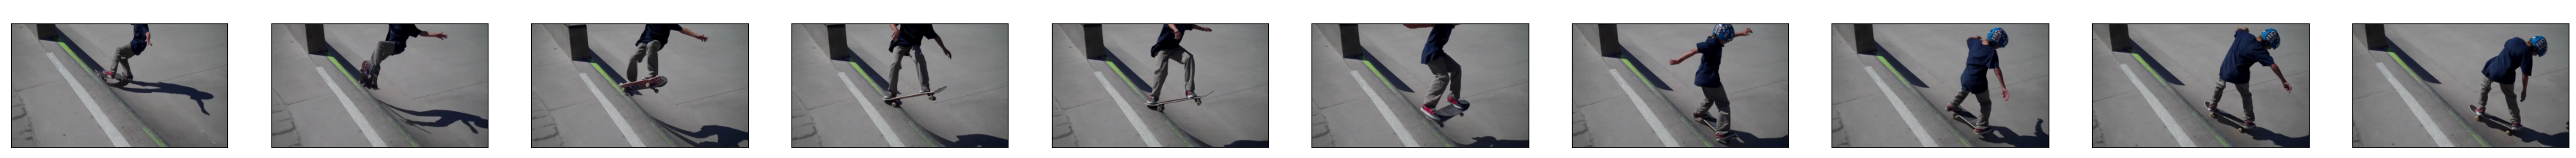

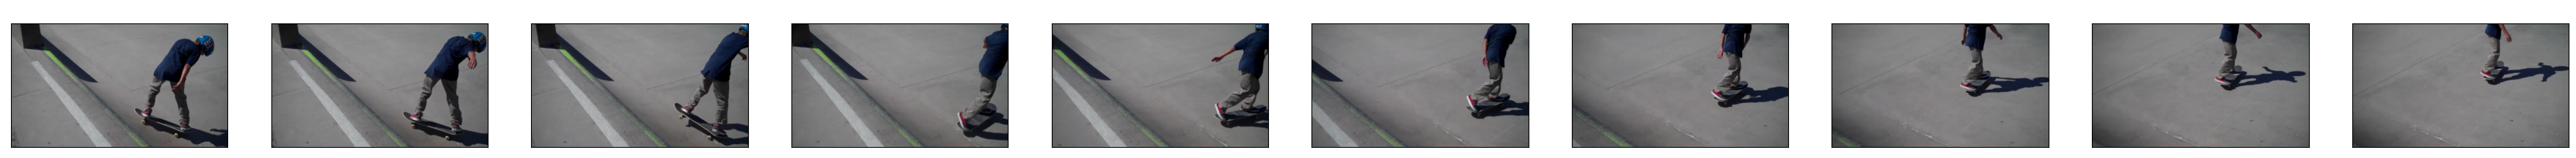

In [11]:
display_cluster_img(12, labels, all_train_dataset, nb_col=10, figsize = (45, 5))

# Cluster distances

In [12]:
def euc_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def get_kmeans_cluster_sizes(centers, labels, embeddings):
    cluster_distances = {}
    for i, center in enumerate(centers):
        all_dist = []
        for j, embed in enumerate(embeddings):
            if labels[j] == i:
                dist = euc_distance(center, embed).item()
                all_dist.append(dist)
        cluster_distances[i] = all_dist

    distance_to_center = []
    for j, embed in enumerate(embeddings):
        dist = euc_distance(np.zeros_like(embed), embed).item()
        distance_to_center.append(dist)

    normalize_value = np.median(distance_to_center)
    avg_cluster_diameter = 0
    for k, v in cluster_distances.items():
        v = sorted(v)
        # diameter = v[int(0.9*len(v))]
        # get the 3rd quartile
        diameter = v[int(0.75*len(v))]
        diameter = diameter / normalize_value
        avg_cluster_diameter += diameter
    avg_cluster_diameter /= len(cluster_distances)

    return avg_cluster_diameter, cluster_distances, distance_to_center

In [13]:
# resnet layer 2-3
avg_cluster_diameter, cluster_distances, distance_to_center = get_kmeans_cluster_sizes(centers, labels, embeddings)
print(avg_cluster_diameter)

0.38532353472769393


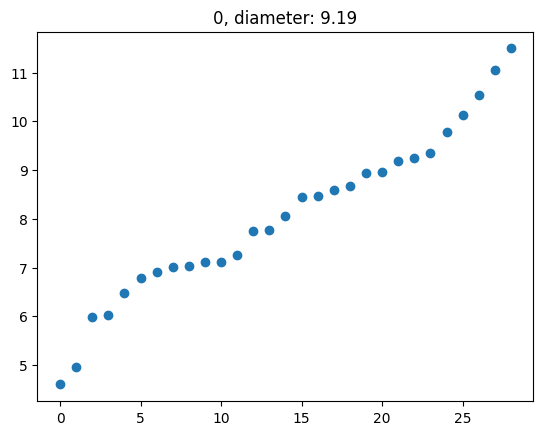

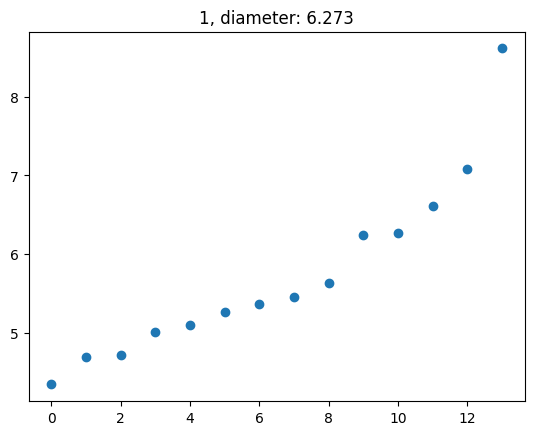

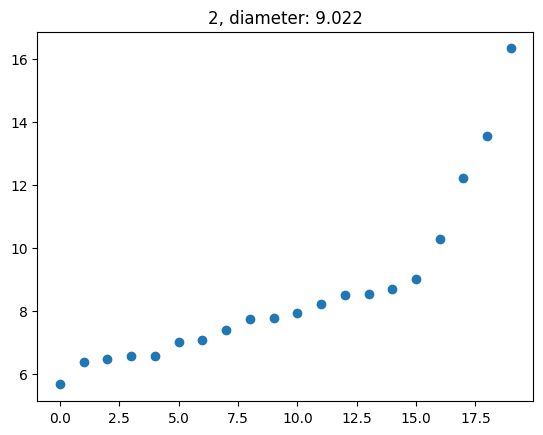

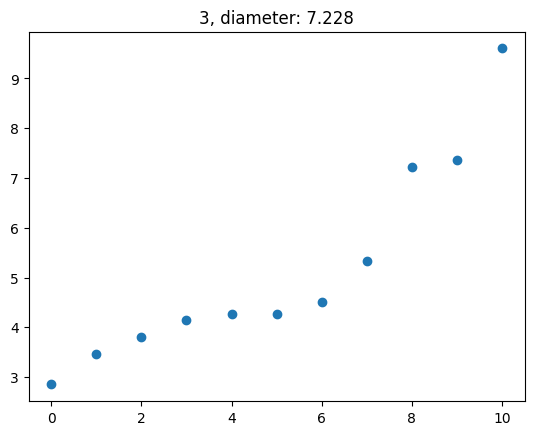

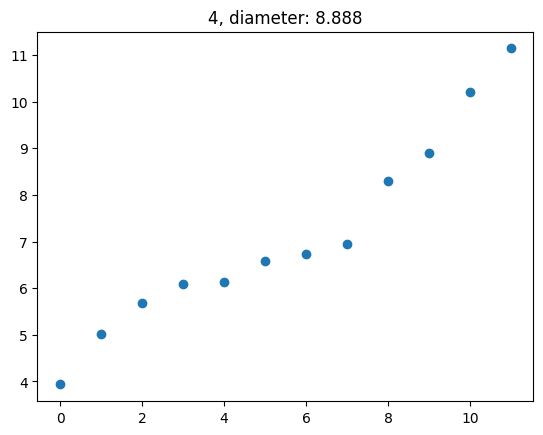

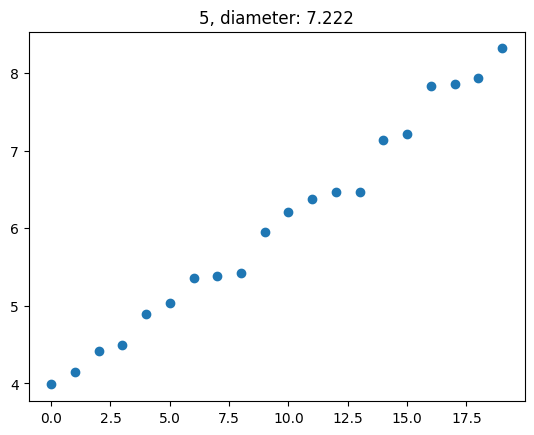

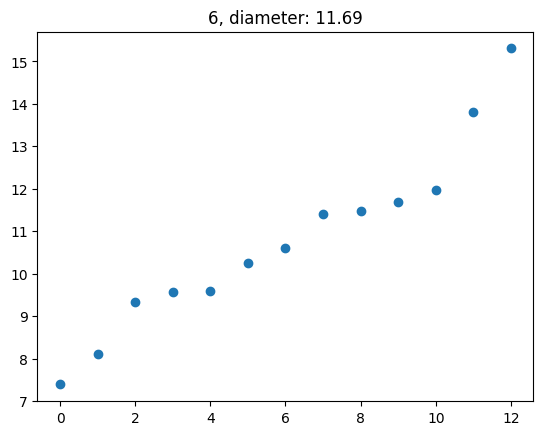

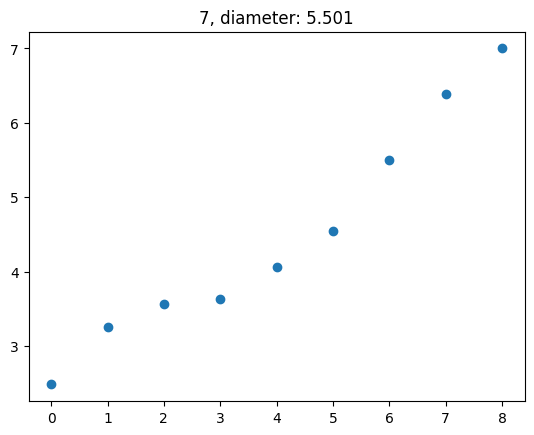

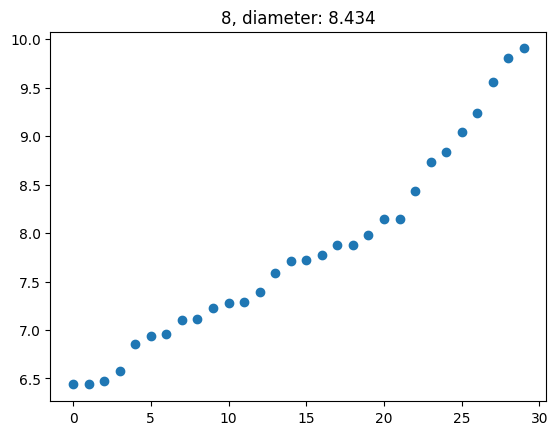

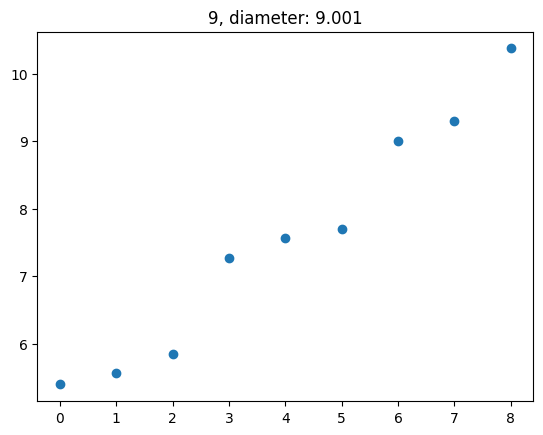

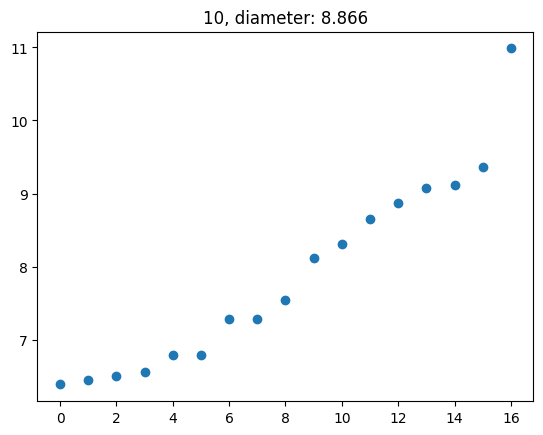

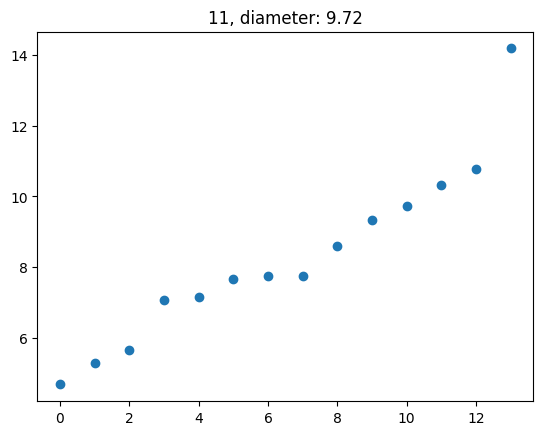

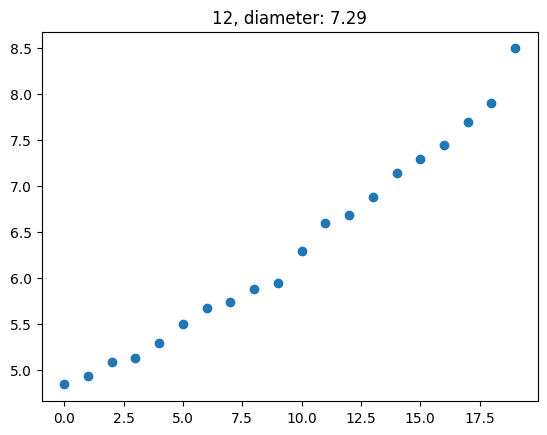

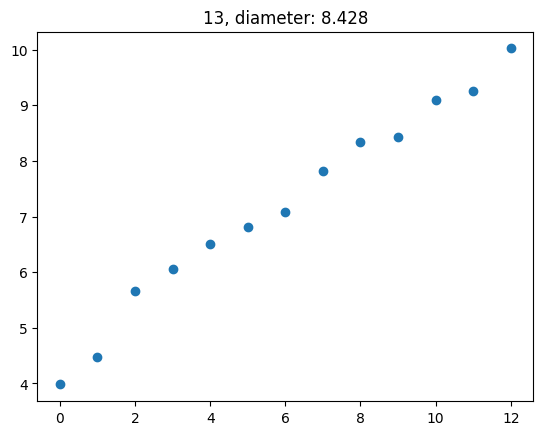

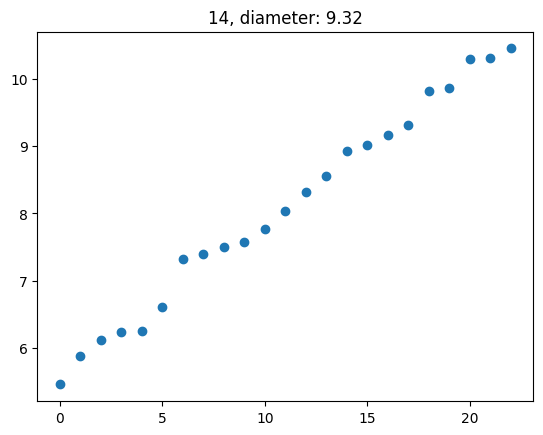

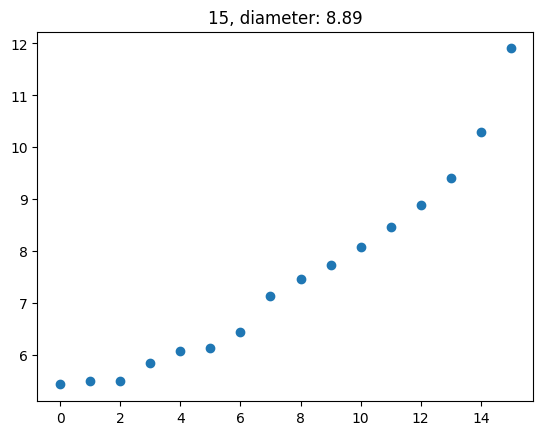

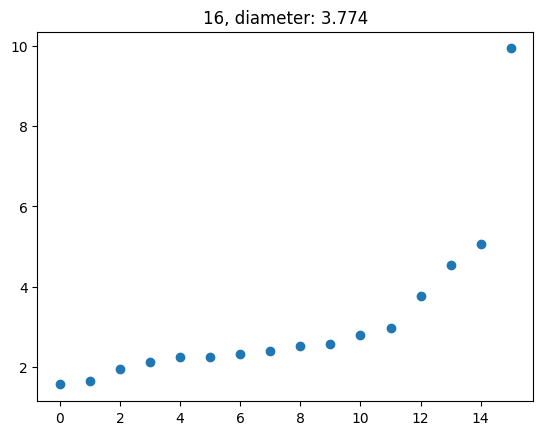

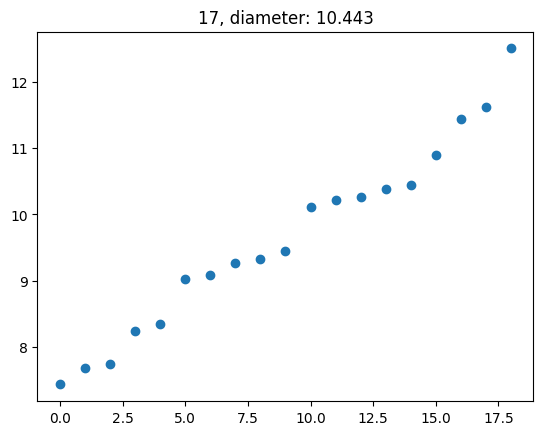

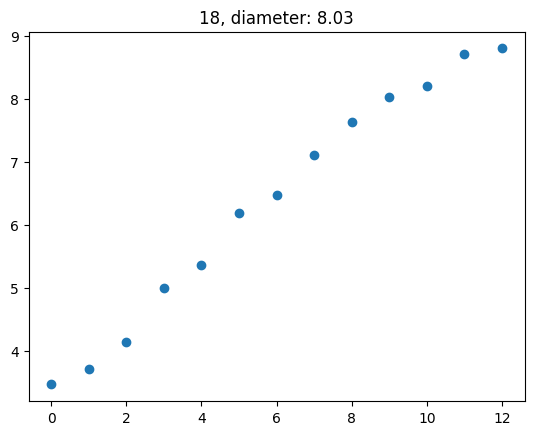

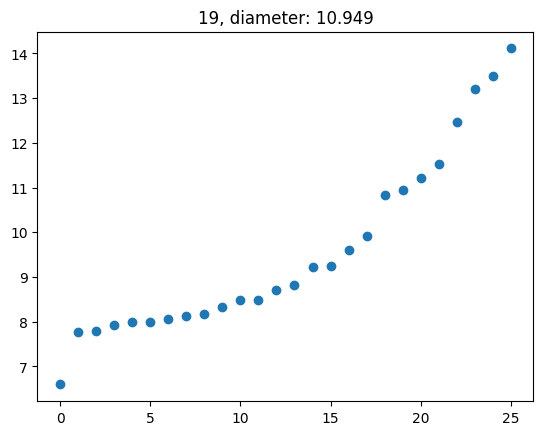

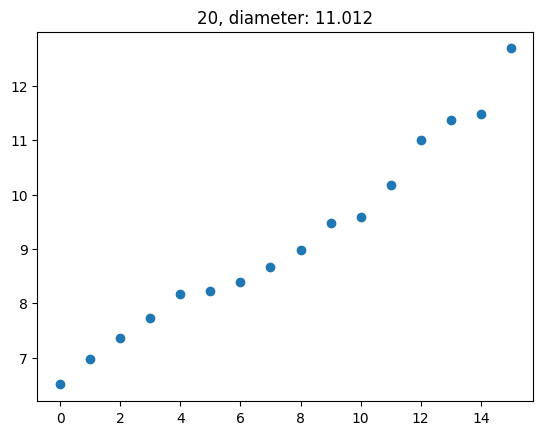

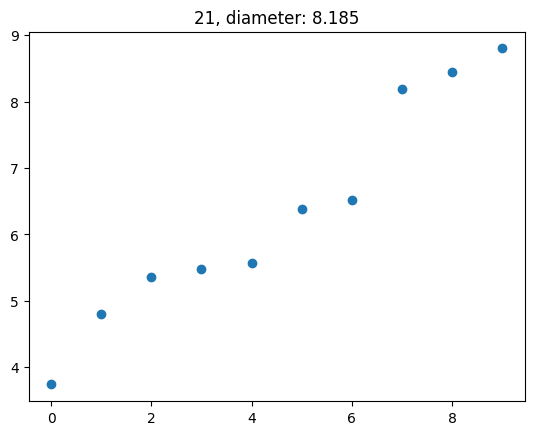

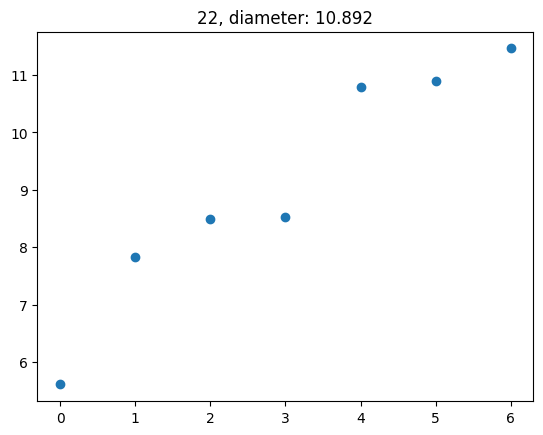

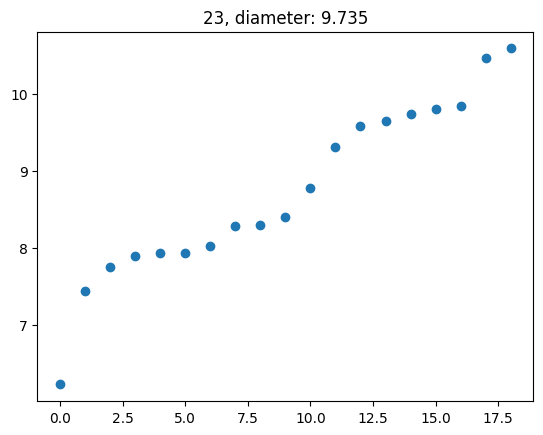

In [14]:
for k, v in cluster_distances.items():
    v = sorted(v)
    diameter = v[int(0.75*len(v))]
    plt.scatter([i for i in range(len(v))], v)
    plt.title(f'{k}, diameter: {round(diameter, 3)}')
    plt.show()

In [48]:
def general_kmeans_cluster_size(embeddings, num_query, init_training_size=10, nb_seeds=10, nb_rounds=10):
    general_cluster_size = 0
    for SEED in range(nb_seeds):
        for cluster_nb in range(init_training_size + num_query, init_training_size + (num_query + 1) * nb_rounds, num_query):
            labels, centers = do_kmeans(embeddings, cluster_nb, SEED=SEED)
            avg_cluster_diameter, cluster_distances, distance_to_center = get_kmeans_cluster_sizes(centers, labels, embeddings)
            # print(cluster_nb, round(avg_cluster_diameter, 5))
            general_cluster_size += avg_cluster_diameter
    general_cluster_size /= nb_seeds * nb_rounds
    return general_cluster_size

In [53]:
general_cluster_size = general_kmeans_cluster_size(embeddings, num_query, init_training_size=len(train_dataset), nb_seeds=5, nb_rounds=10)
print(embedding_name)
print(round(general_cluster_size, 6))

embeddings_resnet_layer2-3_SEED=0.pth
0.032033


In [59]:
general_cluster_size = general_kmeans_cluster_size(embeddings, num_query, init_training_size=len(train_dataset), nb_seeds=5, nb_rounds=10)
print(embedding_name)
print(round(general_cluster_size, 6))

embeddings_simCLR.pth
0.259437


# TSNE

##### functions

In [36]:
def get_video_class_ranges():
    class_ranges = []
    start = 0
    end = 0
    curr_c = None
    keys = []
    for k, v in train_dataset.data_path.items():
        if curr_c is None:
            curr_c = k[:2]
            end += len(v)
        else:
            if k[:2] == curr_c:
                end += len(v)
            else:
                class_ranges.append((start, end))
                start = end
                end += len(v)
                keys.append(curr_c)
                curr_c = k[:2]
                
    class_ranges.append((start, end))
    return class_ranges

def get_class_ranges(train_dataset, labels):
    class_ranges = []
    start = 0
    end = 0
    keys = []
    for k, v in train_dataset.data_path.items():
        end = len(v) + start
        class_ranges.append((start, end))
        start = end
        keys.append(k)
        
    pred_per_class = {}
    for n, (i, j) in enumerate(class_ranges):
        class_label = labels[i: j]
        uniq = np.unique(class_label)
        this_class = {}
        total = 0
        for u in uniq:
            this_class[u] = np.sum(class_label == u)
            total += np.sum(class_label == u)
        list_ = sorted([(k, v) for k, v in this_class.items()], key=lambda x: x[1], reverse=True)
        this_class = {k: f'{round(100*v/total, 2)}%' for k, v in list_}
        pred_per_class[keys[n]] = this_class
    embedding_score = 0
    for k, v in pred_per_class.items():
        k2, v2 = next(iter(v.items()))
        embedding_score += float(v2[:-1])
    embedding_score = embedding_score/len(pred_per_class)
    return class_ranges, keys, pred_per_class , embedding_score

def do_TSNE(embedding, class_ranges, keys, labels, figsize=(30, 20)):
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embedding)
    x = tsne_results[:, 0]
    y = tsne_results[:, 1]

    plt.figure(figsize=(20, 10))
    np.random.shuffle(COLORS)
    for i, (start, end) in enumerate(class_ranges):
        color = COLORS[i]
        im = plt.scatter(x[start:end], y[start:end], c = color, label=keys[i])
    plt.legend()
    # fig, axs = plt.subplots(2, 1, figsize=figsize)
    # for i, (start, end) in enumerate(class_ranges):
    #     color = COLORS[i]
    #     axs[0].scatter(x[start:end], y[start:end], c = color, label=keys[i])
    # axs[1].scatter(x, y, c = labels)
    # plt.legend()
    return COLORS[:i+1], x, y

def recolor_TSNE(x, y, colors, class_ranges, keys):
    plt.figure(figsize=(20, 10))
    for i, (start, end) in enumerate(class_ranges):
        color = colors[i]
        im = plt.scatter(x[start:end], y[start:end], c = color, label=keys[i])
    plt.legend()

def do_pca(embedding):
    pca = PCA(n_components=2)
    pca.fit(embedding)
    print(pca.explained_variance_ratio_)
    pca_embedding = pca.transform(embedding)
    return pca_embedding

##### .

In [37]:
class_ranges, keys, pred_per_class, score2 = get_class_ranges(train_dataset, labels)
score2

76.03166666666668

In [38]:
pred_per_class

{'01-00': {15: '97.92%', 13: '2.08%'},
 '01-01': {13: '60.0%', 6: '20.0%', 2: '13.33%', 15: '6.67%'},
 '01-02': {8: '88.89%', 14: '11.11%'},
 '01-03': {8: '87.5%', 6: '9.38%', 2: '1.56%', 5: '1.56%'},
 '01-04': {2: '53.66%', 11: '46.34%'},
 '01-05': {0: '87.23%', 13: '6.38%', 14: '6.38%'},
 '01-06': {5: '91.43%', 14: '5.71%', 17: '2.86%'},
 '01-07': {5: '46.77%', 17: '43.55%', 2: '6.45%', 15: '3.23%'},
 '13-00': {13: '44.64%', 14: '39.29%', 2: '10.71%', 15: '5.36%'},
 '13-01': {10: '35.42%', 7: '31.25%', 16: '28.12%', 6: '5.21%'},
 '13-02': {6: '80.0%', 14: '12.0%', 8: '4.0%', 10: '4.0%'},
 '13-03': {10: '53.33%', 13: '26.67%', 6: '6.67%', 7: '6.67%', 14: '6.67%'},
 '13-04': {3: '72.73%', 14: '22.73%', 2: '4.55%'},
 '12-00': {4: '100.0%'},
 '12-01': {9: '92.78%', 15: '5.15%', 2: '2.06%'},
 '12-02': {1: '100.0%'},
 '12-03': {12: '76.27%', 1: '20.34%', 13: '3.39%'},
 '12-04': {2: '100.0%'}}

/Users/feiwu/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/feiwu/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


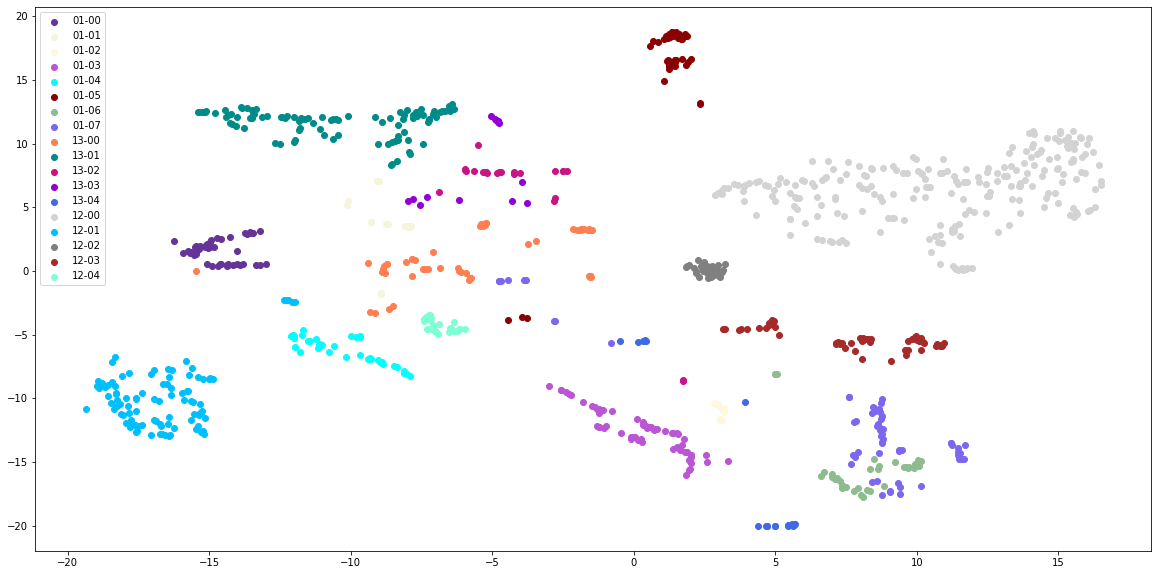

In [40]:
# pca_embedding = do_pca(embedding_resnets)
colors, x, y = do_TSNE(embedding, class_ranges, keys, labels)

In [44]:
colors_labels = []
for l in labels:
    colors_labels.append(colors[l])

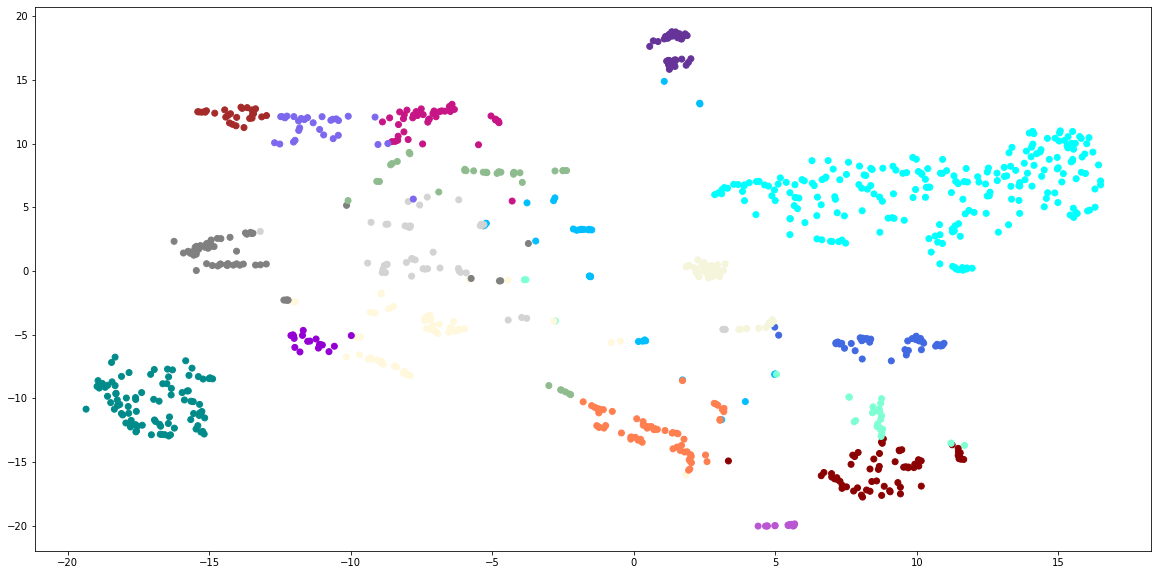

In [45]:
plt.figure(figsize=(20, 10))
im = plt.scatter(x, y, c = colors_labels)

In [32]:
colors[2] = 'black'

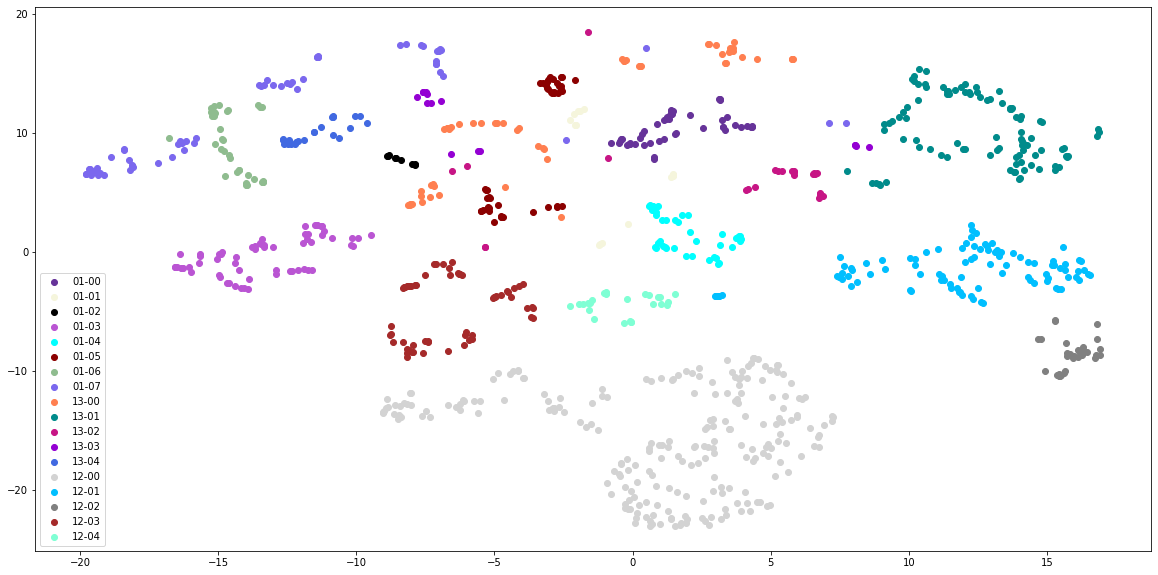

In [33]:
recolor_TSNE(x, y, colors, class_ranges, keys)

In [ ]:
#### to display a color bar on the side
#ax = plt.subplot()
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="2%", pad=0.05)
#plt.colorbar(im, cax=cax);
# for i, txt in enumerate(texts):
#     plt.annotate(txt, (x[i], y[i]));

# for i, img in enumerate(images):
#     plt.imshow(img.permute((1,2,0)))
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(names[i],color='white')
#     plt.show()

# Matrix View

##### functions

In [19]:
def euc_distance(x1, x2):
    return torch.sqrt(torch.sum((x1 - x2)**2))
    
def get_dist(embedding, video_name, train_dataset):
    distances = collections.defaultdict(list)
    keys = list(train_dataset.data_path.keys())

    ind = keys.index(video_name)
    start, end = class_ranges[ind]
    video_emb = embedding[start: end]
    names = train_dataset.data_pool[start:end]
    names = names[:, 0]

    path_type = '../../dataset/segmentation/auris_seg/dataset/images'
    for i, embed1 in enumerate(video_emb):
        for j, embed2 in enumerate(video_emb):
            dist = euc_distance(embed1, embed2)
            distances[names[i][len(path_type):-4]].append((dist.item(), names[j][len(path_type):-4]))
    return distances

def show_all_similarity(dists):
    distances = {}
    for k, v in dists.items():
        distances[k] = sorted(v, key=lambda x: x[0])
    for k, v in distances.items():
        v = v[1:]
        fig, axs = plt.subplots(1, 6, figsize=(20, 10))
        src_img = np.array(Image.open(DATAPATH + f'images/{k}.png'))
        axs[0].imshow(src_img)
        axs[0].set_title(k[12:])
        for i in range(1, 6):
            closest_img = np.array(Image.open(DATAPATH + f'images/{v[i - 1][1]}.png'))
            axs[i].imshow(closest_img)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            axs[i].set_title(str(v[i - 1][1][12:]) + ' ' + str(v[i - 1][0])[:4])
        plt.show()

def show_all_img(dists):
    col = 0
    nb_col = 10
    for k, v in dists.items():
        src_img = np.array(Image.open(DATAPATH + f'images/{k}.png'))
        if col == 0:
            fig, axs = plt.subplots(1, nb_col, figsize=(15, 10))
        axs[col].imshow(src_img)
        axs[col].set_xticks([])
        axs[col].set_yticks([])
        # axs[col].set_title(classes[i], color='white')
        col += 1
        if col == nb_col:
            plt.show()
            col = 0
    if col < nb_col:
        for i in range(col, nb_col):
            axs[i].imshow(np.zeros((220, 220)))
            axs[i].set_xticks([])
            axs[i].set_yticks([])

def show_segment(start, end, class_ranges, train_dataset):
    fig, axs = plt.subplots(1, end - start, figsize=(20, 5))

    for i in range(start, end):
        seg_start, _ = class_ranges[seg_ind]
        img, _, _  = train_dataset[seg_start + i]
        axs[i - start].imshow(img.permute((1,2,0)))
        axs[i - start].set_title(i, color='white')
        axs[i - start].set_xticks([])
        axs[i - start].set_yticks([])

def show_matrix(distances):
    key_list = list(distances.keys())
    key_list = sorted(key_list, key=lambda x: int(x[len('/xx-xx/frame'):]))
    matrix = np.array([[d[0] for d in distances[key]] for key in key_list])
    plt.figure(figsize=(8,8))
    plt.imshow(matrix);

##### .

In [51]:
seg_ind = 10
print(keys[seg_ind])
# distances_resnet = get_dist(embedding, keys[seg_ind], train_dataset)
distances_resnet = get_dist(embedding, '13-01', train_dataset)
# show_all_similarity(distances_resnet)

13-02


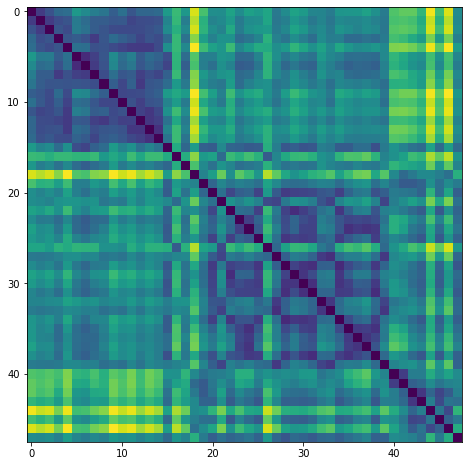

In [27]:
show_matrix(distances_resnet)

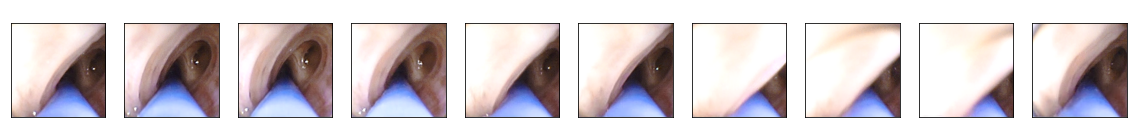

In [209]:
show_segment(start=40, end=50, class_ranges=class_ranges, train_dataset=train_dataset)

In [ ]:
show_all_img(distances_resnet)